In [1]:
import pandas as pd
import numpy as np
import os,glob
import matplotlib.pyplot as plt
from matplotlib import dates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 모델 생성
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping
tf.random.set_seed(777)

In [3]:
file_list = glob.glob("./data/*.csv")

In [4]:
print(len(file_list))

25


In [5]:
def load_time_series_data(data, sequence_length):
    window_length = sequence_length + 1
    x_data = []
    y_data = []

    for i in range(0, len(data) - window_length + 1):
        window = data[i:i + window_length, :]
        x_data.append(window[:-1,:])
        y_data.append(window[-1, [-1]])
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    return x_data, y_data

In [6]:
def MinMaxScale(array, MIN, MAX):
    return (array - MIN) / (MAX - MIN)

def reverseMinMaxScale(array, MIN, MAX):
    return (array *(MAX-MIN)) + MIN

In [7]:
def preprocessing(file, sequence_length):    
    df = pd.read_csv(file)
    data = df[['AREA_PPLTN_MIN']].to_numpy()
    
    x_data, y_data = load_time_series_data(data, sequence_length)
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, shuffle=False) #시각화를 위해 shuffle=False 옵션 사용
    
    return x_train, y_train, x_test, y_test, data, df

In [8]:
def modeling(x_train, y_train, x_test, y_test, gu, place, sequence_length):
    clear_session()
    model = Sequential([
        Input(shape=(sequence_length, 1)),
        LSTM(units=32, activation='relu'),
        Dense(units=32, activation='relu'),
        Dense(units=1)
    ])
    model.compile(loss='mse', optimizer='adam')
    # model.summary()

    es = EarlyStopping(monitor = 'val_loss',
                       min_delta = 0,
                       patience = 5,
                       verbose = 1,
                       restore_best_weights = True)
    history = model.fit(x_train, y_train, epochs=100, verbose=0, callbacks=[es], validation_split=0.3)
    
    # save model
    model.save(f'.\\models\\{gu}_{place}.h5')
    return model

In [9]:
def plot(data, y_predict_train, y_predict_test, sequence_length, df):
    # x축
    x = pd.to_datetime(df["NOW"]).to_numpy().reshape(-1,1)
    
    plt.figure(figsize=(60,5))
    plt.xlim(x[0],x[-1])
    plt.plot(x, data[:, [-1]].flatten(), label='실제 유동인구')

    y_predict_train_plot = np.empty(data[:, [0]].shape)
    y_predict_train_plot[:, :] = np.nan
    y_predict_train_plot[sequence_length:len(y_predict_train) + sequence_length, :] = y_predict_train
    plt.plot(x, y_predict_train_plot.flatten(), label='학습 데이터 예측 유동인구')

    
    y_predict_test_plot = np.empty(data[:, [0]].shape)
    y_predict_test_plot[:, :] = np.nan
    y_predict_test_plot[len(y_predict_train) + sequence_length:, :] = y_predict_test
    plt.plot(x, y_predict_test_plot.flatten(), label='테스트 데이터 예측 유동인구')
    
    print(y_predict_train_plot.shape, y_predict_test_plot.shape)
    plt.xticks(rotation=45)
    ax = plt.gca()
    ax.xaxis.set_major_locator(dates.HourLocator(interval=6))
    ax.xaxis.set_minor_locator(dates.HourLocator(interval=1))
    plt.legend()
    plt.grid()
    plt.show()

# 1시간 뒤 예측 모델 생성

In [ ]:
for file in file_list:
    gu = os.path.basename(file).split(".")[0].split("_")[0]
    place = os.path.basename(file).split(".")[0].split("_")[1]

    # 1시간 뒤 예측
    sequence_length = 6            
    x_train, y_train, x_test, y_test, data, df = preprocessing(file, sequence_length)
    model = modeling(x_train, y_train, x_test, y_test, gu, place, sequence_length)

# 2시간 뒤 예측 모델 생성

In [ ]:
for file in file_list:
    gu = os.path.basename(file).split(".")[0].split("_")[0]
    place = os.path.basename(file).split(".")[0].split("_")[1]

    # 2시간 뒤 예측
    sequence_length = 12          
    x_train, y_train, x_test, y_test, data, df = preprocessing(file, sequence_length)
    model = modeling(x_train, y_train, x_test, y_test, gu, place, sequence_length)

# 예측 결과 시각화

16/16 [==============================] - 0s 3ms/step
(1712, 1) (1712, 1)


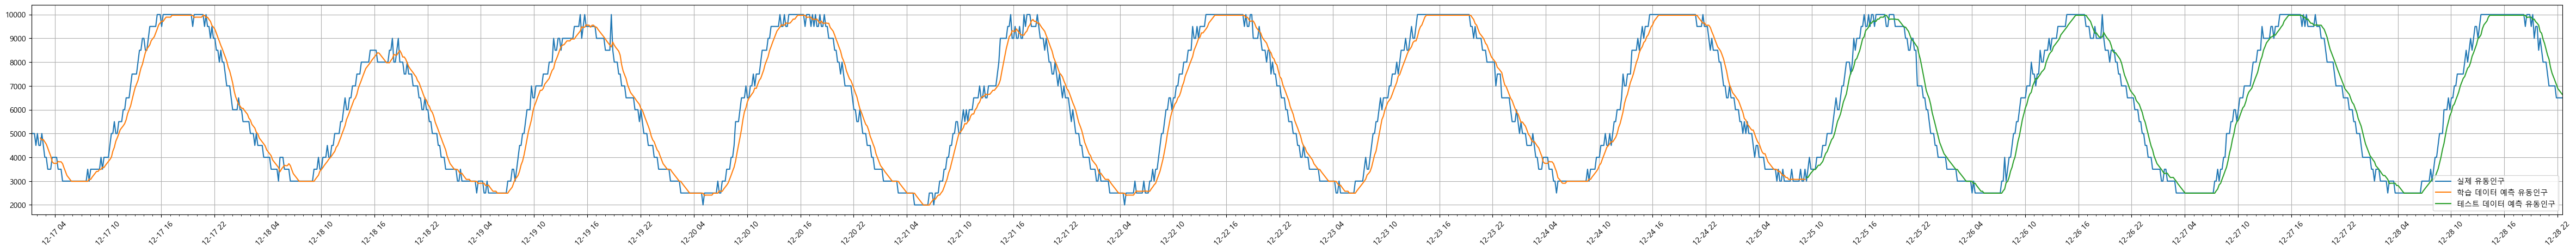

In [10]:
# yongsan_이태원 관광특구.h5
model2 = keras.models.load_model("./models_1hr/yongsan_이태원 관광특구.h5")
file = file_list[-1]
sequence_length = 6
x_train, y_train, x_test, y_test, data, df = preprocessing(file, sequence_length)
y_predict_train = model2.predict(x_train)
y_predict_test = model2.predict(x_test)
plot(data, y_predict_train, y_predict_test, sequence_length, df)

16/16 [==============================] - 0s 2ms/step
(1712, 1) (1712, 1)


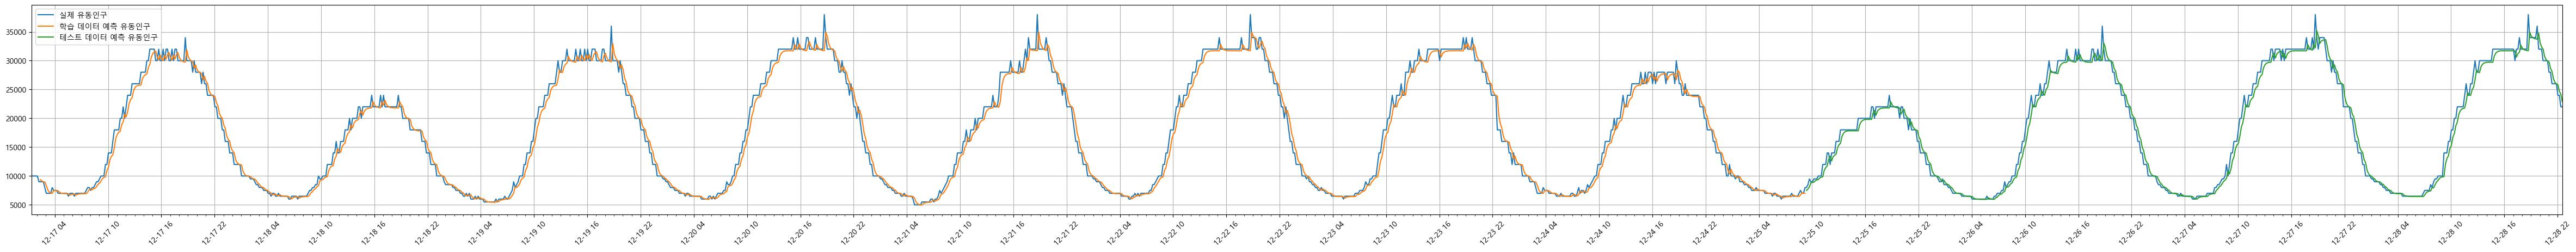

In [11]:
# gangnam_가로수길.h5
model2 = keras.models.load_model("./models_1hr/gangnam_가로수길.h5")
file = file_list[0]
sequence_length = 6
x_train, y_train, x_test, y_test, data, df = preprocessing(file, sequence_length)
y_predict_train = model2.predict(x_train)
y_predict_test = model2.predict(x_test)
plot(data, y_predict_train, y_predict_test, sequence_length, df)